# Tapping response

Participant 0, Song 0 - Tap Data: [[ 2.414875  3.436553  4.551111  5.665669  6.780227  7.801905  8.916463
  10.03102  11.052698 12.167256 13.281814 14.396372 15.449433 16.532608
  17.647165 18.668844 19.783401 20.897959 22.012518 23.127075 24.148752
  25.263311 26.284988 27.492426 28.514105 29.628662 30.743219 31.857779
  32.879456 33.994015]]
  Skipping Participant 0, Song 0 due to insufficient data.
Participant 1, Song 0 - Tap Data: [[ 1.764717  2.600635  3.436553  4.365352  5.20127   6.037188  6.873106
   7.801905  8.637823  9.473742 10.402539 11.145578 12.074376 13.003175
  13.839093 14.675012 15.51093  16.346848 17.275646 18.111565 18.947483
  19.783401 20.7122   21.548119 22.384037 23.312834 24.148752 25.077551
  25.913469 26.749388 27.585306 28.514105 29.350023 30.185942 31.114738
  31.950657 32.786575 33.622494]]
  Skipping Participant 1, Song 0 due to insufficient data.
Participant 2, Song 0 - Tap Data: [[ 2.693515  3.436553  4.272471  5.01551   5.851429  6.687347  7.523265
  

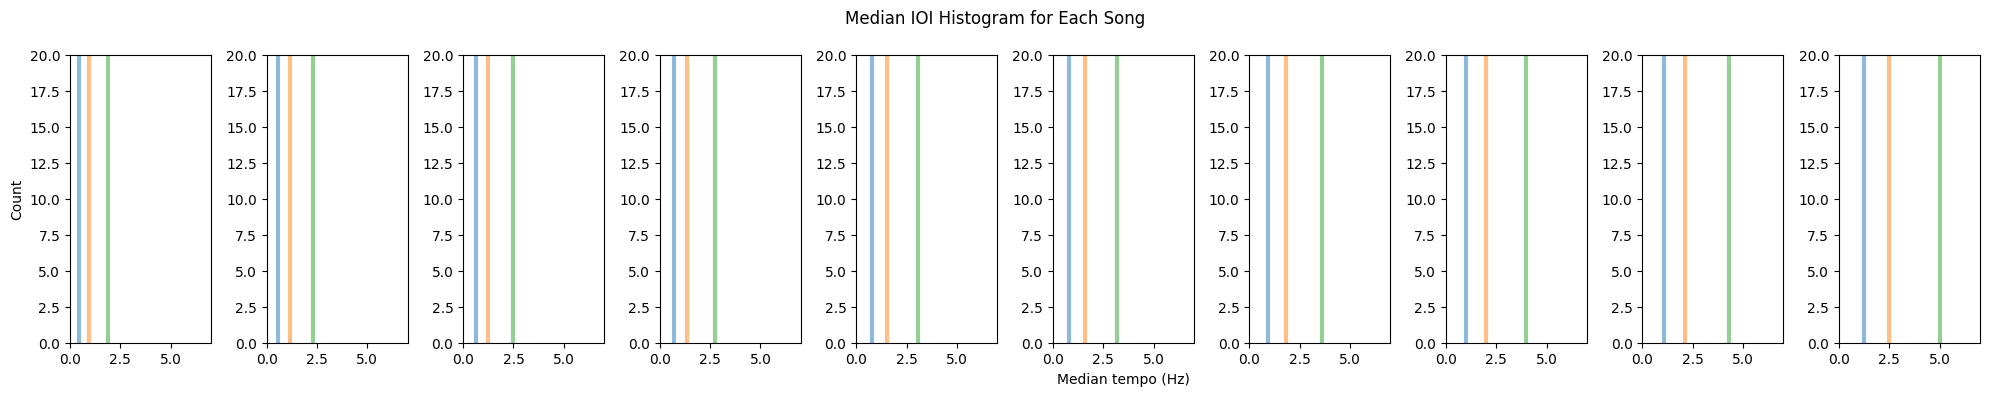

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import h5py

# Define tempo values in Hz for the 10 songs
tempos_HZ = [55.97 / 60.0, 69.44 / 60.0, 74.26 / 60.0, 82.42 / 60.0,
             91.46 / 60.0, 96.15 / 60.0, 108.70 / 60.0, 120.00 / 60.0,
             128.21 / 60.0, 150.00 / 60.0]
tempos_HZ = np.array(tempos_HZ)

# Define the tempo variations (0.5x, 1x, 2x tempos)
allTempos = np.tile(tempos_HZ, (3, 1)) * np.array([[0.5], [1], [2]])

# Load TapIt.mat using h5py (assuming it's a v7.3 .mat file)
tap_it_path = r'C:\Users\napat\Documents\GitHub\BCC_2024\TapIt\TapIt.mat'
with h5py.File(tap_it_path, 'r') as f:
    allTappedResponse = f['allTappedResponse']  # Reference to allTappedResponse dataset

    # Parameters
    nParticipants, nSongs = allTappedResponse.shape
    nSongs = min(nSongs, allTempos.shape[1])  # Ensure nSongs does not exceed allTempos columns
    tapStart, tapStop = 15, 32
    interpStep = 0.5  # Temporal resolution for interpolated data
    interpX = np.arange(0, 35, interpStep)

    # Initialize an array to store interpolated data
    allLinInterpIOI_Hz = np.zeros((len(interpX), nParticipants, nSongs))

    # Interpolate IOI for each participant and song
    for s in range(nSongs):
        for p in range(nParticipants):
            # Dereference and retrieve the tapping data for each participant and song
            currIn = np.array(f[allTappedResponse[p, s]])  # Access the actual data
            print(f"Participant {p}, Song {s} - Tap Data: {currIn}")  # Debugging actual data

            # Calculate the midpoints and IOIs in Hz if enough points exist
            if len(currIn) > 1:
                currX = (currIn[1:] + currIn[:-1]) / 2
                currIOI_sec = currIn[1:] - currIn[:-1]
                currIOI_Hz = 1 / currIOI_sec

                # Debugging: check lengths
                print(f"  Midpoints (X) Length: {len(currX)}, IOI (Y) Length: {len(currIOI_Hz)}")

                # Check if lengths match for interpolation
                if len(currX) == len(currIOI_Hz):
                    # Interpolate to get IOI values on a consistent time axis
                    interp_func = interp1d(currX, currIOI_Hz, kind='linear', bounds_error=False, fill_value="extrapolate")
                    allLinInterpIOI_Hz[:, p, s] = interp_func(interpX)
                else:
                    print(f"  Skipping interpolation for Participant {p}, Song {s} due to length mismatch.")
            else:
                print(f"  Skipping Participant {p}, Song {s} due to insufficient data.")

# Plotting
fig, axes = plt.subplots(1, nSongs, figsize=(20, 4))
for s in range(nSongs):
    ax = axes[s]
    # Plot tempo lines
    for c in range(3):
        ax.plot([allTempos[c, s], allTempos[c, s]], [0, 20], linewidth=3, alpha=0.5)

    # Define xaxUse as boolean array for indexing
    xaxUse = (interpX >= tapStart) & (interpX <= tapStop)
    
    # Median IOI histogram
    currN, currX = np.histogram(np.nanmedian(allLinInterpIOI_Hz[xaxUse, :, s], axis=1), bins=np.arange(0.5, 12, 0.5))
    ax.bar(currX[:-1], currN, width=0.6, color='k', edgecolor='none')

    ax.set_xlim([0, 7])
    ax.set_ylim([0, 20])

    if s == 5:
        ax.set_xlabel('Median tempo (Hz)')
    if s == 0:
        ax.set_ylabel('Count')

plt.suptitle('Median IOI Histogram for Each Song', fontsize=12)
plt.tight_layout()
plt.show()


In [21]:
import hdf5storage
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import os

# ----------------------------
# Configuration and File Paths
# ----------------------------

# Update these paths to point to your actual file locations
tap_it_path = r'C:\Users\napat\Documents\GitHub\BCC_2024\TapIt\TapIt.mat'
tempo_hz_path = r'C:\Users\napat\Documents\GitHub\BCC_2024\TapIt\tempoHz.mat'
colors_path = r'C:\Users\napat\Documents\GitHub\BCC_2024\TapIt\colors.mat'

# ----------------------------
# Load Data with hdf5storage
# ----------------------------

def load_mat_with_hdf5storage(file_path):
    """
    Load a MATLAB .mat file using hdf5storage.
    """
    try:
        data = hdf5storage.loadmat(file_path)
        print(f"Successfully loaded {file_path} with hdf5storage.")
        return data
    except Exception as e:
        print(f"Failed to load {file_path} with hdf5storage: {e}")
        return None

# Load TapIt.mat
tap_it_data = load_mat_with_hdf5storage(tap_it_path)
if tap_it_data is None:
    raise FileNotFoundError(f"Could not load {tap_it_path}")

# Load tempoHz.mat
tempo_hz_data = load_mat_with_hdf5storage(tempo_hz_path)
if tempo_hz_data is None:
    raise FileNotFoundError(f"Could not load {tempo_hz_path}")

# Load colors.mat
colors_data = load_mat_with_hdf5storage(colors_path)
if colors_data is None:
    raise FileNotFoundError(f"Could not load {colors_path}")


ModuleNotFoundError: No module named 'hdf5storage'